# 1. Imports

In [1]:
import re
import sqlite3
import warnings

import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap

from matplotlib              import pyplot        as plt
from plotly                  import express       as px
from sklearn                 import preprocessing as pp
from matplotlib              import cm
from sqlalchemy              import create_engine

from pandas_profiling        import ProfileReport
from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn.metrics         import silhouette_score, silhouette_samples
from sklearn.cluster         import KMeans, DBSCAN
from sklearn.preprocessing   import MinMaxScaler
from sklearn.decomposition   import PCA
from sklearn.manifold        import TSNE
from sklearn.ensemble        import RandomForestRegressor
from sklearn.mixture         import GaussianMixture
from sklearn.neighbors       import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer

C:\Users\gutsc\anaconda3\envs\insiders_clustering\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")
    
    
    warnings.filterwarnings('ignore')

In [3]:
jupyter_settings()

## 1.2. Load Dataset

In [4]:
# load data
df_raw = pd.read_csv( '../data/Ecommerce.csv',  encoding= 'unicode_escape' )

# drop extra column
df_raw.drop( columns='Unnamed: 8', axis=1, inplace=True)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 2. Data Description

In [6]:
df2 = df_raw.copy()

## 2.1. Rename Columns

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

# rename columns
df2.columns = cols_new
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 2.2. Data Dimensions

In [8]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 541909
Number of columns: 8


## 2.3. Data Types

In [9]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4. Check NA

In [10]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.5. Replace NA

In [11]:
df_missing = df2.loc[df2['customer_id'].isna(), :]
df_not_missing = df2.loc[~df2['customer_id'].isna(), :]

In [12]:
# max customer_id
df_not_missing['customer_id'].max()

18287.0

In [13]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000 + len(df_backup), 1 )
df_backup.head()

,invoice_no,customer_id
622,536414,19000
1443,536544,19001
1970,536545,19002
1971,536546,19003
1972,536547,19004


In [14]:
# merge original with reference
df2 = pd.merge( df2, df_backup, on='invoice_no', how='left' )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id_x,country,customer_id_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [15]:
# coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first( df2['customer_id_y'] )

# drop extra columns
df2.drop( columns=['customer_id_x', 'customer_id_y'], axis=1, inplace=True )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [16]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [17]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

## 2.6. Change dtypes

In [18]:
# invoice date
df2['invoice_date'] = pd.to_datetime( df2['invoice_date'], format='%d-%b-%y' )

# customer_id
df2['customer_id'] = df2['customer_id'].astype( int )
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [19]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 2.7. Descriptive Statistics

In [20]:
num_attributes = df2.select_dtypes( include=['int32', 'int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int32', 'int64', 'float64', 'datetime64[ns]'] )

### 2.7.1. Numerical Attributes

In [21]:
# central tendency
_mean   = pd.DataFrame( num_attributes.apply( np.mean ) ).T
_median = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion
_std   = pd.DataFrame( num_attributes.apply( np.std ) ).T
_min   = pd.DataFrame( num_attributes.apply( np.min ) ).T
_max   = pd.DataFrame( num_attributes.apply( np.max ) ).T
_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
_skew  = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
_kurtosis  = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
summary = pd.concat( [_min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


* **Negative quantity** - It could mean a returning.
* **Unit price equal to zero** - Could it mean a promotion?

### 2.7.2. Categorical Attributes

In [22]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### 2.7.2.1. Invoice_no

In [23]:
# cat_attributes['invoice_no'].astype( int ) # It throws an error
index = df2['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) )
df2[index].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2016-11-29,3.45,United Kingdom,17548
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2016-11-29,1.65,United Kingdom,17548
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2016-11-29,1.65,United Kingdom,17548
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2016-11-29,4.25,United Kingdom,17897


In [24]:
# unique values
len( df2.loc[index, 'invoice_no'].drop_duplicates()  )

3839

In [25]:
# checking if all invoices with a letter indicates has a negative quantity
df_letter_invoices = df2[index]
print( 'Total number of invoices with a letter: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of invoices with a letter and negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices with a letter: 9291
Total number of invoices with a letter and negative quantity: 9288


#### 2.7.2.2. Stock_code

In [26]:
index = df2['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+.*$', x ) ) )
df2[index].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1423,536540,C2,CARRIAGE,1,2016-11-29,50.00,EIRE,14911
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
2239,536569,M,Manual,1,2016-11-29,1.25,United Kingdom,16274
2250,536569,M,Manual,1,2016-11-29,18.95,United Kingdom,16274
3041,536592,DOT,DOTCOM POSTAGE,1,2016-11-29,607.49,United Kingdom,19014
4406,536779,BANK CHARGES,Bank Charges,1,2016-11-30,15.00,United Kingdom,15823


In [27]:
# unique values
print( len( df2.loc[index, 'stock_code'].drop_duplicates() ) )
print( df2.loc[index, 'stock_code'].unique())

33
['POST' 'D' 'C2' 'DOT' 'M' 'BANK CHARGES' 'S' 'AMAZONFEE' 'DCGS0076'
 'DCGS0003' 'gift_0001_40' 'DCGS0070' 'm' 'gift_0001_50' 'gift_0001_30'
 'gift_0001_20' 'DCGS0055' 'DCGS0072' 'DCGS0074' 'DCGS0069' 'DCGS0057'
 'DCGSSBOY' 'DCGSSGIRL' 'gift_0001_10' 'PADS' 'DCGS0004' 'DCGS0073'
 'DCGS0071' 'DCGS0068' 'DCGS0067' 'DCGS0066P' 'B' 'CRUK']


#### 2.7.2.3. Country

In [28]:
df2['country'].value_counts( normalize=True )

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

# 3. Data Filtering

In [29]:
df3 = df2.copy()

## 3.1. Numerical Attributes

In [30]:
# unit price > 0
df3 = df3.loc[ df3['unit_price'] > 0.010, : ]

# stock code == number
df3 = df3[~df3['stock_code'].isin( ['POST', 'D', 'C2', 'DOT', 'M', 'BANK, CHARGES', 'S', 'AMAZONFEE', 'DCGS0076'
, 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50', 'gift_0001_30'
, 'gift_0001_20', 'DCGS0055', 'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057'
, 'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073'
, 'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'] )]

# quantity - negative numbears means product returns
df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] > 0, :]

## 3.2. Categorical Attributes

In [31]:
# drop description
df3 = df3.drop( columns='description', axis=1 )

In [32]:
# map
df3 = df3[~df3['country'].isin( ['European Community', 'Unspecified'] )]

In [33]:
# bad users (based on the Univariate Analysis)
df3 = df3[~df3['customer_id'].isin( [16446] )]

# 4. Feature Engineering

In [34]:
df4 = df3.copy()
df_purchases = df3_purchases.copy()
df_returns = df3_returns.copy()

## 4.1. Feature Creation

The dataset granularity should be customers, because the clusters will be for customers, but it is a unique key composed of product (stock_code) and date (invoice_date). So it is necessary to change the granularity.

In [35]:
# data reference
df_ref = df4[['customer_id']].drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 4.1.1. Gross Revenue

In [36]:
# Gross Revenue (quantity * price)
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

# Monetary
df_monetary = df_purchases[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id',  how='left')
df_ref.head()

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3232.59
2,12583,6705.38
3,13748,948.25
4,15100,876.00


### 4.1.2. Recency - Day from last purchase

In [37]:
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days
0,17850,5391.21,372.0
1,13047,3232.59,56.0
2,12583,6705.38,2.0
3,13748,948.25,95.0
4,15100,876.00,333.0


### 4.1.3. Quantity of purchases

In [38]:
df_freq = df_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().rename( columns={"invoice_no":"qtd_purchases"}).reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases
0,17850,5391.21,372.0,34.0
1,13047,3232.59,56.0,9.0
2,12583,6705.38,2.0,15.0
3,13748,948.25,95.0,5.0
4,15100,876.00,333.0,3.0


### 4.1.4. Quantity of Items Purchased

In [39]:
df_freq = df_purchases[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().rename( columns={"quantity":"qtd_items"}).reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items
0,17850,5391.21,372.0,34.0,1733.0
1,13047,3232.59,56.0,9.0,1390.0
2,12583,6705.38,2.0,15.0,5028.0
3,13748,948.25,95.0,5.0,439.0
4,15100,876.00,333.0,3.0,80.0


### 4.1.5. Quantity of Products Purchased

In [40]:
df_freq = df_purchases[['customer_id', 'stock_code']].groupby( 'customer_id' ).count().rename( columns={"stock_code":"qtd_products"}).reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products
0,17850,5391.21,372.0,34.0,1733.0,297.0
1,13047,3232.59,56.0,9.0,1390.0,171.0
2,12583,6705.38,2.0,15.0,5028.0,232.0
3,13748,948.25,95.0,5.0,439.0,28.0
4,15100,876.00,333.0,3.0,80.0,3.0


### 4.1.6. Average Ticket Value

In [41]:
df_avg_ticket = df_purchases[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().rename( columns={"gross_revenue":"avg_ticket"} ).reset_index()
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000


### 4.1.7. Average Recency Days

In [42]:
df_aux = df4[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True] )
df_aux['previous_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis=1 ) 

df_aux = df_aux.drop( ['invoice_date', 'previous_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency
df_avg_rec_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_rec_days, on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000


### 4.1.8. Returns

In [43]:
df_ret = df_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={"quantity":"qtd_returns"} )
df_ret['qtd_returns'] = df_ret['qtd_returns'] * -1
df_ref = pd.merge( df_ref, df_ret, how='left', on='customer_id' )
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,40.0
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,35.0
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,50.0
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,22.0


### 4.1.9. Frequency Purchase

In [44]:
df_aux = ( df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby( 'customer_id' )
                                                                      .agg( max_date = ('invoice_date', 'max'),
                                                                            min_date = ('invoice_date', 'min'),
                                                                            days     = ('invoice_date', lambda x: (( x.max() - x.min() ).days) + 1 ),
                                                                            buy      = ('invoice_no', 'count') ) ).reset_index()

# frequency 
df_aux['frequency'] = df_aux[['buy', 'days']].apply( lambda x: x['buy'] / x['days'] if x['days'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.head()

,customer_id,gross_revenue,recency_days,qtd_purchases,qtd_items,qtd_products,avg_ticket,avg_recency_days,qtd_returns,frequency
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,40.0,17.000000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,35.0,0.028302
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,50.0,0.040323
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.0,0.017921
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,22.0,0.073171


## 4.2. Checking NAs

In [45]:
# checking possible NAs created by the merge
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_purchases         91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
qtd_returns            0
frequency             91
dtype: int64

# 5. EDA

In [46]:
df5 = df_ref.dropna().copy()

## 5.3. Data Space Study

In [47]:
cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtd_products', 'frequency', 'qtd_returns']
df53 = df5[ cols_select ].copy()

In [48]:
mm = MinMaxScaler()

df53['gross_revenue']          = mm.fit_transform( df53[['gross_revenue']] )
df53['recency_days']           = mm.fit_transform( df53[['recency_days']] )
df53['qtd_products']           = mm.fit_transform( df53[['qtd_products']] )
df53['qtd_returns']            = mm.fit_transform( df53[['qtd_returns']] )
df53['frequency']              = mm.fit_transform( df53[['frequency']] )

X = df53.copy()

### 5.3.1. PCA

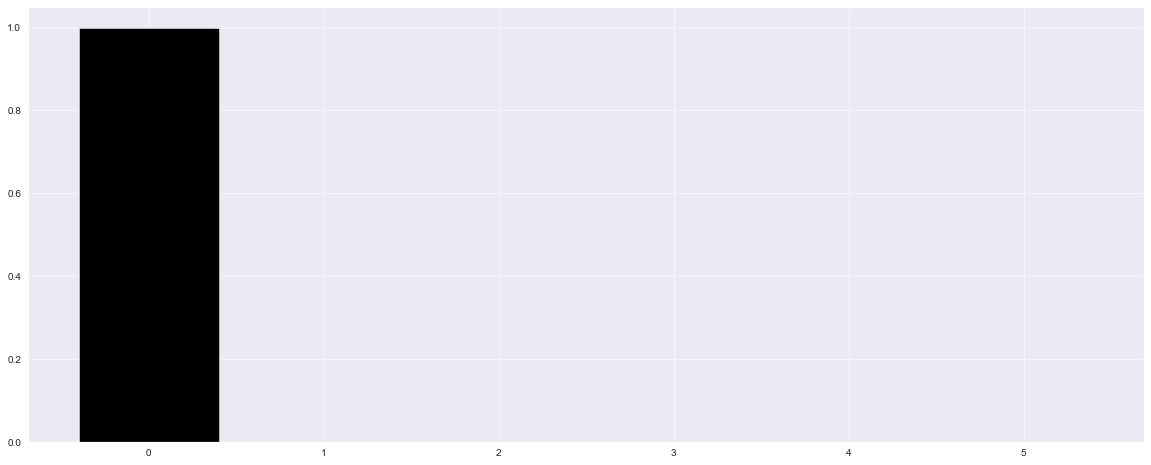

In [49]:
pca = PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

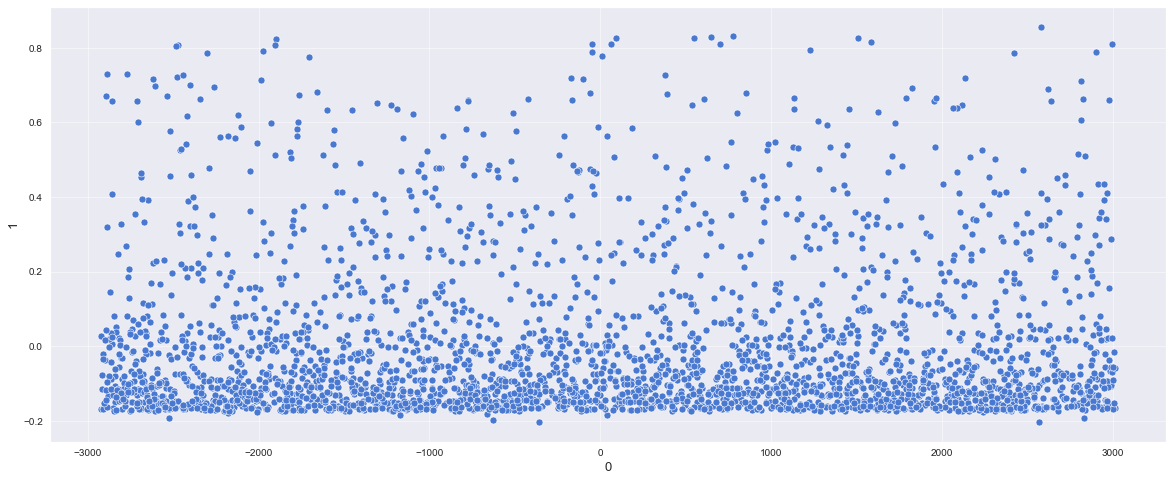

In [50]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 5.3.2. UMAP

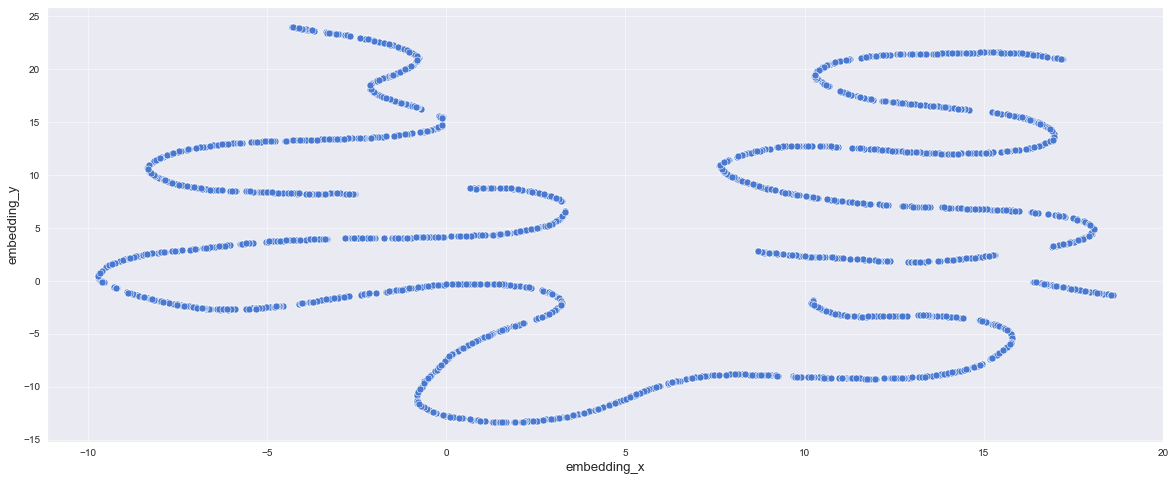

In [51]:
reducer = umap.UMAP( random_state=0 )
embedding = reducer.fit_transform( X )

df_umap = pd.DataFrame()

# embedding 
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_umap )
plt.show();

### 5.3.3. t-SNE

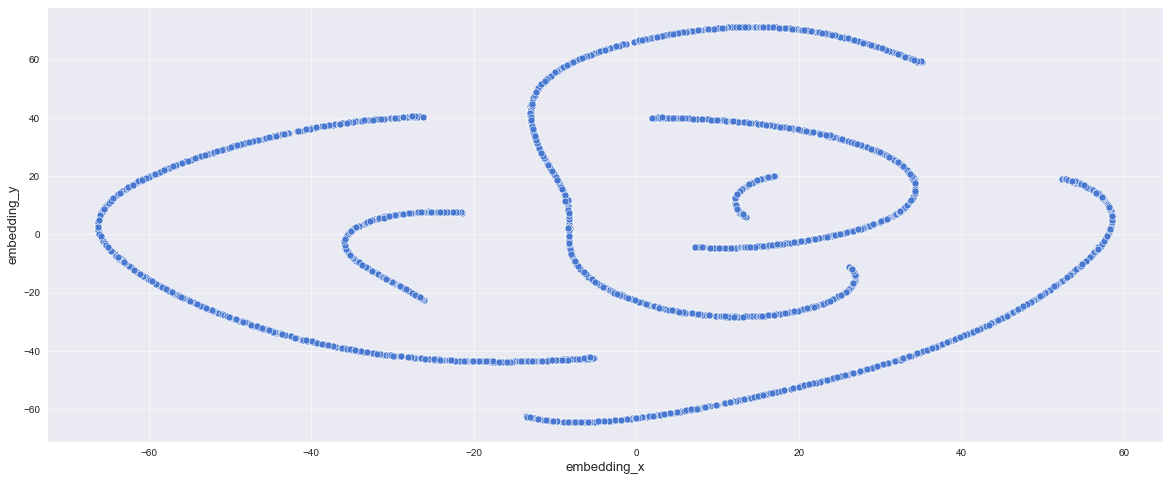

In [52]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=0 )
embedding = reducer.fit_transform( X )

df_tsne = pd.DataFrame()

# embedding 
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot t-SNE
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tsne )
plt.show();

### 5.3.4. Tree-Based Embedding

In [53]:
# training dataset
X = df53.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df53['gross_revenue']

In [54]:
# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=0 )

# model training
rf_model.fit( X, y );

# leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )
df_leaf.shape

(2968, 100)

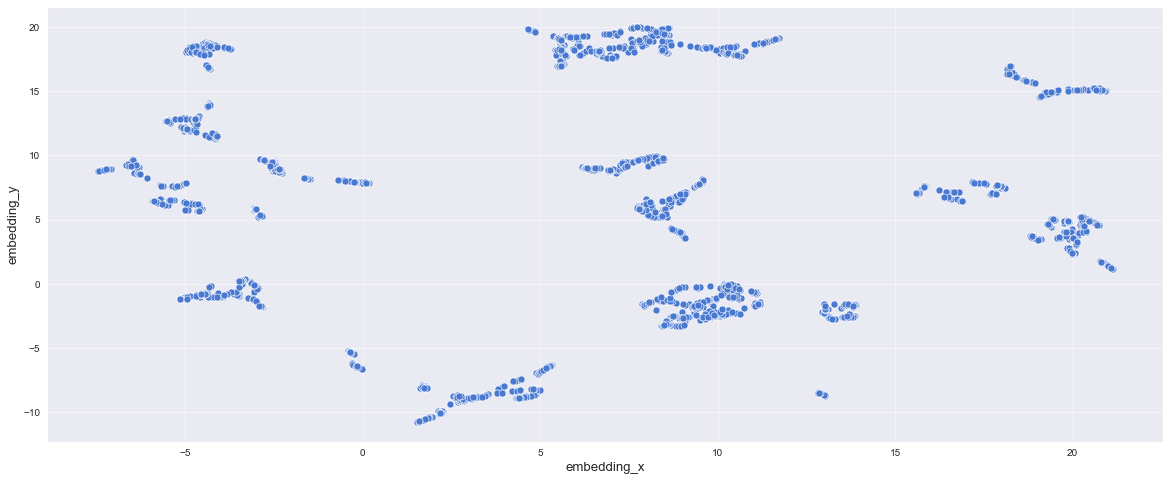

In [55]:
# reduce dimensionality
reducer = umap.UMAP( random_state=0 )
embedding = reducer.fit_transform( df_leaf )

# embedding 
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tree )
plt.show();

# 6. Data Preparation

In [56]:
df6 = df_tree.copy()

# 7. Feature Selection

In [57]:
df7 = df_tree.copy()

# 8. Hyperparameter Fine-Tunning

In [58]:
X = df_tree.copy()
X.head()

,embedding_x,embedding_y
0,7.078088,19.460415
1,19.467587,14.951132
2,7.903790,19.933830
3,-3.167913,-1.106622
4,-5.166347,7.633122


In [59]:
clusters = np.arange( 2, 30, 1 )

## 8.1. K-Means

In [60]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = KMeans( n_clusters=k, random_state=42 )

    # model training 
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

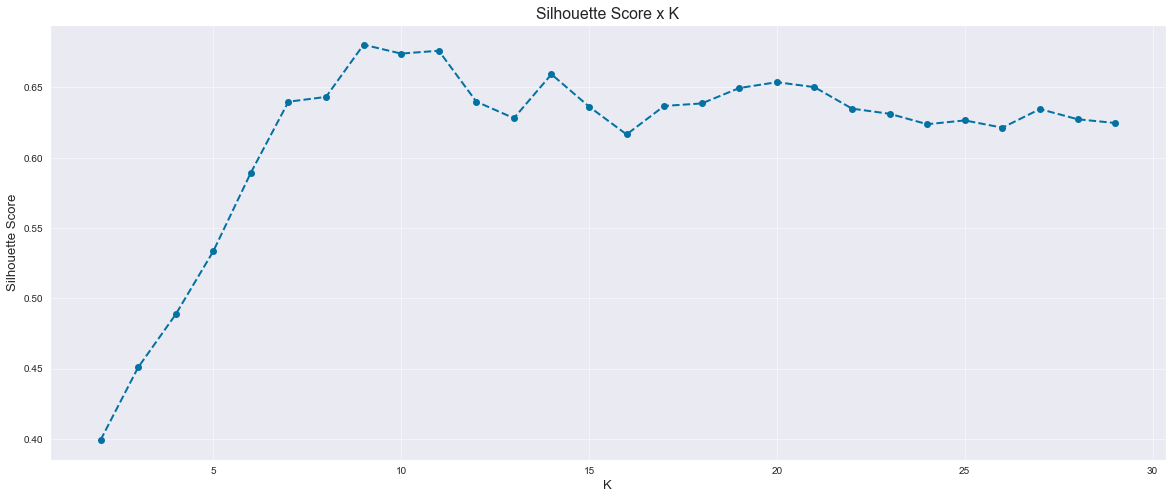

In [61]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Silhouette Score x K' );

## 8.2. GMM

In [62]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k, random_state=42 )

    # model training 
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

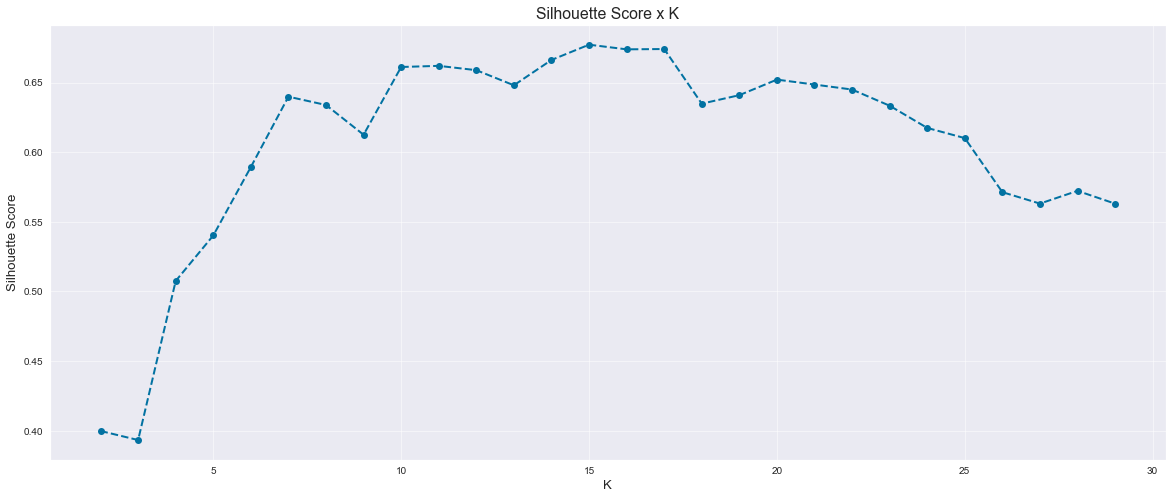

In [63]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Silhouette Score x K' );

## 8.3. Hierarchical Clustering

In [64]:
# model definition and training
hc_model = linkage( X, 'ward' )

In [65]:
hc_list = []

for k in clusters:
    # model definition and training
    hc_model = linkage( X, 'ward' )

    # model predict
    labels = fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

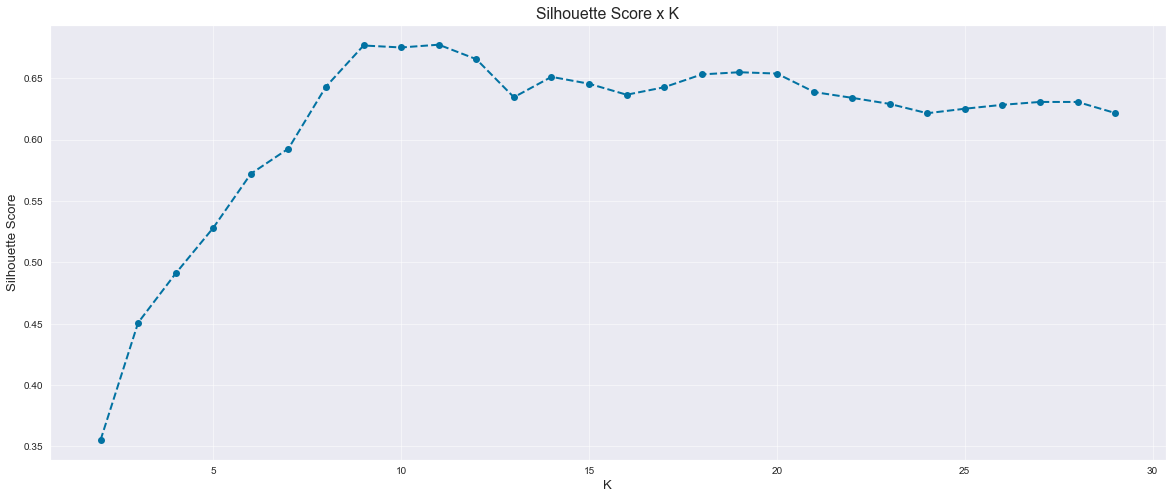

In [66]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Silhouette Score x K' );

## 8.4. Results

In [67]:
df_results = pd.DataFrame(
    {'KMeans':kmeans_list, 'GMM': gmm_list, 'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
KMeans,0.399189,0.450854,0.488593,0.533470,0.589362,0.639879,0.643283,0.680441,0.674103,0.676143,0.639940,0.628152,0.659401,0.636410,0.616581,0.636868,0.638645,0.649618,0.653770,0.650225,0.634943,0.631274,0.623866,0.626571,0.621395,0.634637,0.627411,0.624724
GMM,0.399843,0.393335,0.507555,0.540217,0.589362,0.639879,0.633911,0.612552,0.661195,0.662018,0.658914,0.648066,0.666241,0.677214,0.673872,0.674094,0.634871,0.640961,0.652130,0.648585,0.645007,0.633387,0.617449,0.610130,0.571318,0.563109,0.572258,0.563064
HC,0.355240,0.450874,0.491047,0.528186,0.572220,0.592767,0.643283,0.676779,0.675175,0.677441,0.665630,0.634617,0.651222,0.645622,0.636662,0.642752,0.653221,0.654998,0.653904,0.638790,0.634134,0.629183,0.621582,0.625243,0.628435,0.630784,0.630765,0.621765


# 9. Model Training

## 9.1. K-Means

In [68]:
# model definition
k = 8

kmeans = KMeans( init='random', n_clusters=k, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 9.2. Cluster Validation

In [69]:
# WSS 
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# SS
print( 'SS value: {}'.format( silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 24590.390625
SS value: 0.6432831287384033


# 10. Cluster Analysis

In [70]:
df10 = X.copy()
df10['cluster'] = labels
df10.head()

,embedding_x,embedding_y,cluster
0,7.078088,19.460415,7
1,19.467587,14.951132,1
2,7.903790,19.933830,7
3,-3.167913,-1.106622,6
4,-5.166347,7.633122,6


## 10.1. Visualization Inspection

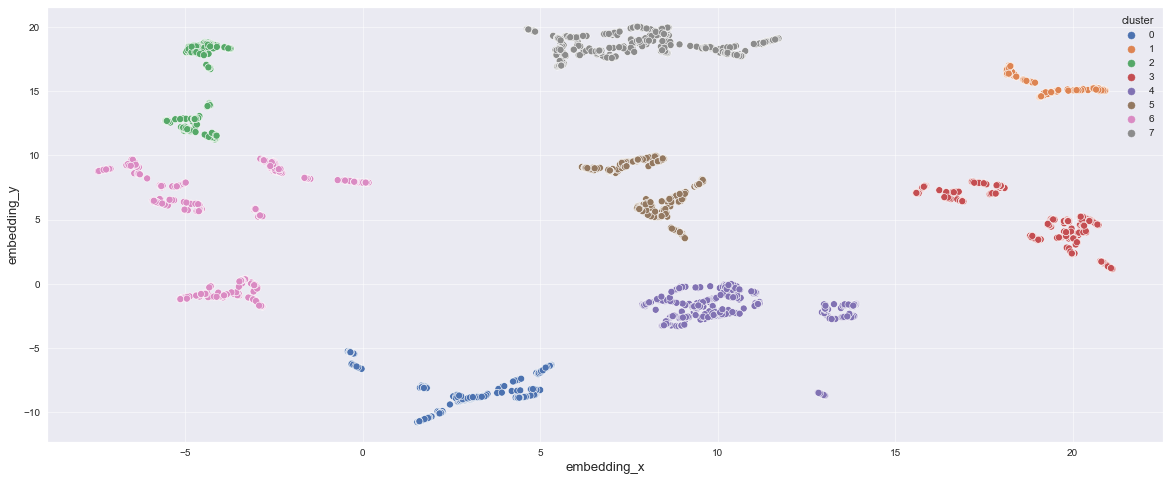

In [71]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df10, palette='deep' );

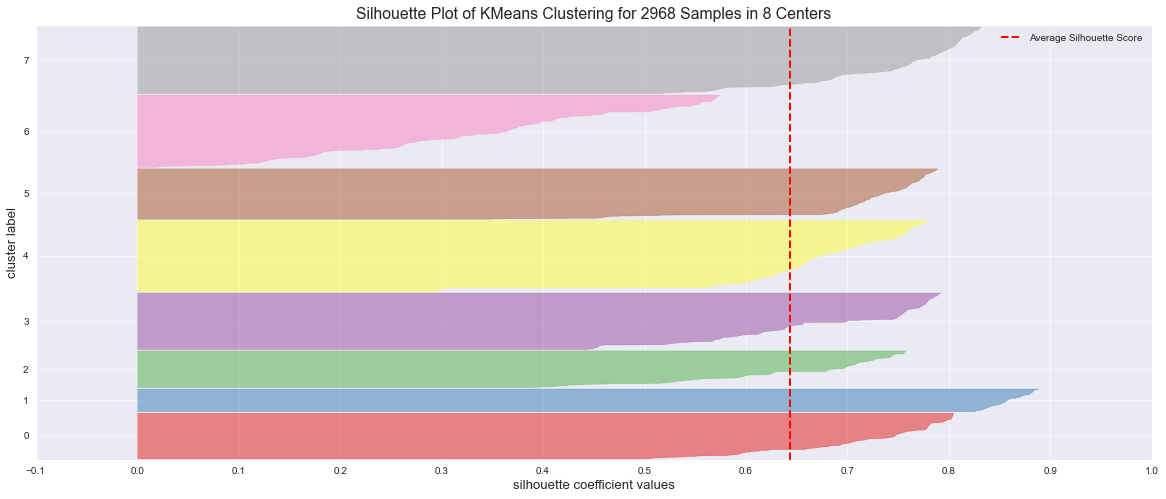

In [72]:
visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick' )
visualizer.fit( X )
visualizer.finalize();

## 10.2. Cluster Profile

In [73]:
df10_aux = df5[cols_select].copy()
df10_aux['cluster'] = labels

# change dtypes
df10_aux['recency_days'] = df10_aux['recency_days'].astype( int )
df10_aux['qtd_products'] = df10_aux['qtd_products'].astype( int )
df10_aux['qtd_returns'] = df10_aux['qtd_returns'].astype( int )

# show
df10_aux.head()

,customer_id,gross_revenue,recency_days,qtd_products,frequency,qtd_returns,cluster
0,17850,5391.21,372,297,17.000000,40,7
1,13047,3232.59,56,171,0.028302,35,1
2,12583,6705.38,2,232,0.040323,50,7
3,13748,948.25,95,28,0.017921,0,6
4,15100,876.00,333,3,0.073171,22,6


In [74]:
# number of customers
df_cluster = df10_aux[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg Gross revenue
df_avg_gross_rev = df10_aux[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_rev, how='inner', on='cluster' )

# Avg Recency days
df_avg_rec_days = df10_aux[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_rec_days, how='inner', on='cluster' )

# Avg frequency
df_avg_invoice_no = df10_aux[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster' )

# Avg quantity of products
df_avg_qtd_products = df10_aux[['qtd_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_qtd_products, how='inner', on='cluster' )

# Avg returns
df_returns = df10_aux[['qtd_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on='cluster' )

# rename columns
df_cluster.rename( columns={ "customer_id":"qtd_customers", "gross_revenue":"avg_gross_revenue", "recency_days":"avg_recency_days", "frequency":"avg_frequency","qtd_products":"avg_qtd_products" ,"qtd_returns":"avg_returns"}, inplace=True )
df_cluster.sort_values( by=['avg_gross_revenue'], ascending=False, inplace=True )
df_cluster

,cluster,qtd_customers,perc_customer,avg_gross_revenue,avg_recency_days,avg_frequency,avg_qtd_products,avg_returns
7,7,469,15.801887,8878.421983,21.415778,0.094471,423.373134,168.908316
1,1,160,5.390836,2938.148375,35.543750,0.057165,172.012500,23.287500
5,5,354,11.927224,2439.726836,45.228814,0.042360,125.172316,25.525424
4,4,499,16.812668,2078.272505,57.965932,0.049283,66.981964,12.603206
3,3,397,13.376011,1683.683728,54.942065,0.050434,88.889169,11.712846
0,0,322,10.849057,970.404317,75.329193,0.074586,37.450311,6.571429
2,2,258,8.692722,650.991783,46.666667,0.029476,13.523256,0.903101
6,6,509,17.149596,597.837367,141.640472,0.379490,18.829077,15.009823


In [75]:
insiders = df_cluster.iloc[0,0]
print( "Insiders: Cluster {}".format(insiders) )

Insiders: Cluster 7


# 11. EDA (With the clusters)

In [76]:
df11 = df10_aux.copy()

## 11.1. Mindmap

![mindmap.png](../img/mindmap.png)

## 11.2. Business Hypotheses

### 11.2.1. Purchase Hypotheses

* **1.** 80% of the customers on the insiders cluster use a credit card as payment method.
* **2.** The customers on the insiders cluster have an average ticket 10% higher than the ones on the cluster 'More products'.
* **3.** The customers on the insiders cluster have a basket size greater than 5 products.
* **4.** The customers on the insiders cluster have a purchase volume greater than 10% of the total purchase.
* **5.** The customers on the insiders cluster have a lower average number of returns than the total average.
* **6.** The median of the revenue from the customers on the insiders cluster is 10% higher than the median of all customers.

### 11.2.2. Customer Hypotheses

* **1.** 10% of the customers on the insiders cluster are between 24 and 35 years old.
* **2.** 40% of the customers locations on the insiders cluster are within a radius of 50km.
* **3.** 5% of the customers on the insiders cluster earn more than 100k dollars per year.
* **4.** 90% of the customers on the insiders cluster have completed higher education.

### 11.2.3. Product Hyphoteses

* **1.** 30% of all products in large packages are purchased by the customers on the insiders cluster.
* **2.** The median of the product prices purchased by the customers on the insiders cluster is 10% higher than the median of all product prices.
* **3.** The average weight of products purchased by customers on the insiders cluster is greater than the average weight of the other clusters.
* **4.** The average age of products purchased by customers on the insiders cluster is less than 15 days.

### 11.2.4. Hypotheses Priority

* **1.** The customers on the insiders cluster have a purchase volume (products) greater than 10% of the total purchase.
* **2.** The customers on the insiders cluster have a purchase volume (invoice) greater than 10% of the total purchase.
* **3.** The customers on the insiders cluster have a lower number of returns than the total average.
* **4.** The median of the revenue from the customers on the insiders cluster is 10% higher than the median of all customers.

## 11.3. Evaluating the Hypotheses

### H1. The customers on the insiders cluster have a purchase volume (products) greater than 10% of the total purchase.

* **TRUE** - The customers on the insiders cluster have a purchase volume (products) of 54.51% of the total purchase.

In [77]:
sales_insiders = df11.loc[df11['cluster'] == insiders, 'qtd_products'].sum()
sales_total = df11.loc[:, 'qtd_products'].sum()

print( '% Sales Insiders: {:.2f}%'.format( 100*sales_insiders / sales_total ) )

% Sales Insiders: 54.51%


### H2. The customers on the insiders cluster have a purchase volume (invoices) greater than 10% of the total purchase.

* **TRUE** - The customers on the insiders cluster have a purchase volume (invoices) of 52.13% of the total purchase.

In [78]:
gmv_insiders = df11.loc[df11['cluster'] == insiders, 'gross_revenue'].sum()
gmv_total = df11.loc[:, 'gross_revenue'].sum()

print( '% GMV Insiders: {:.2f}%'.format( 100*gmv_insiders / gmv_total ) )

% GMV Insiders: 52.13%


### H3. The customers on the insiders cluster have a lower average number of returns than the total average.

* **FALSE** - The customers on the insiders cluster have a **higher** average number of returns than the total average.

In [79]:
avg_return_insiders = df11.loc[df11['cluster'] == insiders, 'qtd_returns'].mean()
avg_return_total = df11['qtd_returns'].mean()

print( 'Avg return Insiders: {:.2f} vs Avg return total: {:.2f}'.format( avg_return_insiders, avg_return_total ) )

Avg return Insiders: 168.91 vs Avg return total: 38.04


### H4. The median of the revenue from the customers on the insiders cluster is 10% higher than the median of all customers.

* **TRUE** - The median of the revenue from the customers on the insiders cluster is 276% higher than the median of all customers.

In [80]:
median_gmv_insiders = df11.loc[df11['cluster'] == insiders, 'gross_revenue'].median()
median_gmv_total = df11.loc[:, 'gross_revenue'].median()

print( 'Median GMV diff: {:.2f}%'.format( 100* (median_gmv_insiders - median_gmv_total) / median_gmv_total ) )

Median GMV diff: 276.65%


## 11.4. Business Questions

### **1.** Who are the eligible customers to the program?

In [81]:
df11.loc[df11['cluster'] == insiders, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int32

### **2.** How many customers will be part of the group?

In [82]:
df11.loc[df11['cluster'] == insiders, 'customer_id'].size

469

### **3.** What are the main characteristics of these customers?

* **Number of customers:** 469 (16%)
* **Average recency days:** 21 days
* **Average frequency:** 0.09 purchases/day
* **Average products purchased:** 423 products
* **Average gross revenue:** $8878,42

### **4.** What is the percentage of revenue contribution from the Insiders?

In [83]:
gmv_insiders = df11.loc[df11['cluster'] == insiders, 'gross_revenue'].sum()
gmv_total = df11.loc[:, 'gross_revenue'].sum()

print( '% Insiders GMV: {:.2f}%'.format( 100 * gmv_insiders / gmv_total ) )

% Insiders GMV: 52.13%


### ~~**5.** What is the expected revenue from the Insiders for the next few months?~~

### **6.** What are the conditions for a person to be eligible as an Insider?

The person has to have similar characteristics to the ones described in question 3 to be eligible, focusing on high gross revenue and quantity of products.

### **7.** What are the conditions for a person to be removed from the Insiders?

The person has to have different characteristics to the ones described in question 3.

### **8.** What is the guarantee that the Insiders are better than the rest?

Based on the percentage of revenue contribution, purchase volume and the median of the revenue compared with all customers, we can see that the insiders stand out.

### **9.** What actions could be done by the marketing team to increase the revenue?

They can focus on the second cluster with the higher gross revenue and stimulate them to buy more or more expensive products, giving discounts or a special service, to put them closer to the insiders.

# 12. Save Clusters

In [84]:
df10_aux.dtypes

customer_id        int32
gross_revenue    float64
recency_days       int32
qtd_products       int32
frequency        float64
qtd_returns        int32
cluster            int32
dtype: object

## 12.1. Insert Into SQLite

In [85]:
# connection
conn = sqlite3.connect( 'insiders_db.sqlite' )

# drop table
query_drop_insiders = """
    DROP TABLE insiders
"""

conn.execute( query_drop_insiders )

## create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        qtd_products    INTEGER,   
        frequency       REAL,
        qtd_returns     INTEGER,
        cluster         INTEGER
    )

"""

conn.execute( query_create_table_insiders )
conn.commit()

In [86]:
# insert table
df10_aux.to_sql( 'insiders', con=conn, if_exists='append', index=False )
conn.close()

In [87]:
# consulting database
conn = create_engine( 'sqlite:///insiders_db.sqlite' )

query = """ 
    SELECT * FROM INSIDERS 
"""

df = pd.read_sql_query( query, conn )

In [88]:
df.shape

(2968, 7)